## Neuron Simulation and Modeling

This is a Jupyter Notebook to implement a model of neurons and then fit a model to the dynamics.

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
from collections import namedtuple

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

# Analysis
# import pysindy as ps

# Own imports from utils file
from utils import *
from visualizations import *

# 7. Program a simulation

Program a simulation of at least 3 neurons. 

**The point here is to implement reasonable facsimiles of different features of neurons that could impact how the system functions. For each feature, demonstrate how it impacts the system (this does not need to be elaborate, just showing the relevant interesting bits is sufficient).**. For example, one can simulate the spatial embeddedness of neurons and their component axons and dendrites computationally by expressing the synapse weights as functions of geometric overlap of axon/dendrite “clouds.” 

Potential features of neurons to look at: it could be things like moderation via neurotransmitters, different types of neurons, actual timing of dynamics that represent physical distance, etc., etc., etc.

Pick something/things of interest to you, implement it, and write your rationale/justification for how you chose to operationalize a biological feature.

**Specific Goals:** I want to see how you translate the biological complexity of what you have been reading about into reasonable computational models. They don’t need to do anything per say, just show some interesting dynamics and show me you understand how to examine differences in those dynamics.

### Network Simulation

#### Simulation Parameters

In [2]:
# Reproducibility
seed = 2302

# Neurons and Their Physical Environment
n = 100 # Number of neurons
n_dim = 2 # Number of dimensions for the physical space that the neurons inhabit
radius = 1 # Width of the physical space that the neurons can inhabit in each dimension. Equidistant in all dimensions. 
distance_connection_probability_exponent = 0.1

# Booleans for visualizations
visualize_nodal_positions_without_edges = True 
visualize_adjacency_matrix = True
visualize_connected_network = True

# Image Paths
base_path = 'figures/'
adjacency_matrix = base_path + 'adjacency-matrix-heatmap.png'
network_graph_path = base_path + 'network-graph.png'

#### Generating Neuron Positions

In [3]:
# Create positions for the neurons in a physical space
np.random.seed(seed)
pos_array = np.random.rand(n, n_dim) * radius

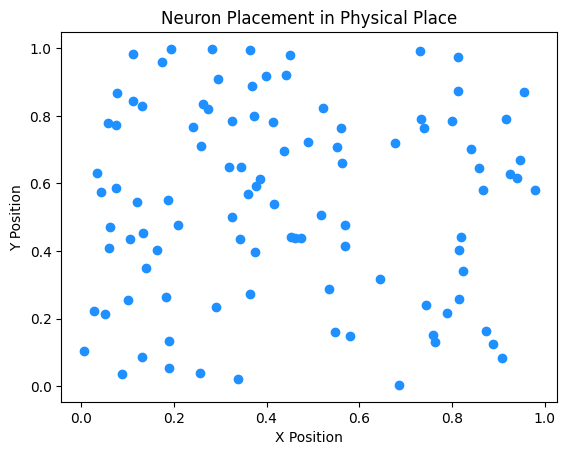

In [4]:
# Look at the neuronal positions if desired
if visualize_nodal_positions_without_edges:
    plt.scatter(pos_array[:, 0], pos_array[:, 1], color = 'dodgerblue')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Neuron Placement in Physical Place')
    
    plt.show()

#### Calculating the Distance Matrix

In [5]:
# Define a connection scheme
# Connection is based on euclidean distance from each other
distance_matrix = np.zeros((n, n), dtype = np.float64) # Create a distance matrix to capture the eucilidean distances between each nodes

# Loop over each node, and calculate it's distance from the other neurons
for i in range(n):

    # Repeat the positions array n-1 times to subtract from the other positions arrays
    # Repeating it (n-1) - 1 so that I don't re-calculate previously calculated distances, this will be a symmetric matrix
    ith_pos_array = np.repeat(
        pos_array[i, :].reshape(1, n_dim), (n-1) - i, axis = 0
    ).reshape((n-1) - i, 2)

    # Calculate the euclidean distance between the nodes 
    distance_vec = np.linalg.norm(
        ith_pos_array - pos_array[(i + 1):, :], axis = 1
    )

    # Fill the distance matrix using this distance vector
    distance_matrix[i, (i + 1):] = distance_vec

# Make it symmetrix by filling in the lower-traingle 
distance_matrix += distance_matrix.T

# Make sure it's symmetric
print('Distance matrix symmetric?:', np.sum(distance_matrix.T == distance_matrix) == n*n)

Distance matrix symmetric?: True


#### Defining the Connections of Neurons

Network Density: 8.65%


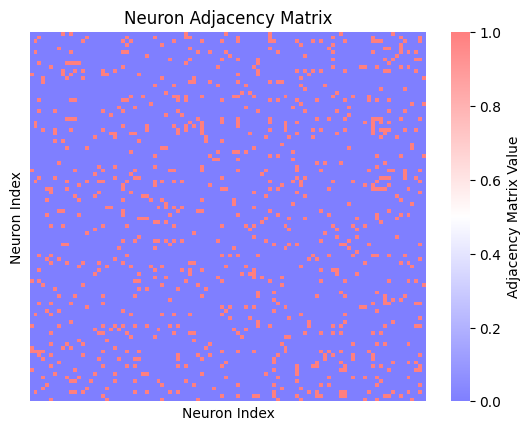

In [10]:
# Now make it so that connection probabilties exponentially decay with distance
distance_connection_probability_exponent_constant = 10

# Scaling distances by the maximum distance in the space so that it is a value value between 0 and 1 for probability. 
max_distance = np.sqrt((radius)**2 * n_dim)
connection_probabilty_exponent = ( distance_matrix / max_distance) * distance_connection_probability_exponent_constant # Add a constant to change the strength of this value
connection_probability = np.exp(-connection_probabilty_exponent)

# Calculate the adjacency matrix as a binomial process based on connection probabilties
A = np.random.binomial(n = 1, p = connection_probability)
A -= np.eye(n, dtype = np.int64) # Subtract out self-connections
edges = np.argwhere(A == 1)

print(f'Network Density: {(np.sum(A) / (A.shape[0] * A.shape[1]) * 100):.2f}%')

if visualize_adjacency_matrix: 
    sns.heatmap(A, cmap = 'bwr', alpha = 0.5, cbar_kws={'label': 'Adjacency Matrix Value'})
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Neuron Index')
    plt.ylabel('Neuron Index')
    plt.title('Neuron Adjacency Matrix')
    plt.savefig(adjacency_matrix)

In [11]:
if visualize_connected_network:
    fig = ShowNetwork(
        pos_array = pos_array,
        edges = edges,
        axis_limit = radius,
        showticklabels = True,
        gridwidth = 2,
        gridcolor = 'black',
        node_size = 15,
        title = 'Neuron Graph Network',
        title_x = 0.5
    )
    fig.write_image(network_graph_path)

#### Creating a Function for Simulation

##### Quick Logic Check for Passing Injected Current Between Neurons

In [12]:
# Test of logic for passing on injected current from one neuron to the next
spike_idx = np.array([0, 1, 0])

# The second neuron has outgoing connections to the first and third neuron
# When it spikes, expect injected current to be going to these two neurons
B = np.array(
    [
        [0, 1, 0],
        [1, 0, 1],
        [1, 0, 0]
    ]
)

spike_idx_diag = np.diag(spike_idx)

# Find that this is the result, so the logic seems to be working
(np.array([15, 15, 15]).reshape(1, 3) @ (spike_idx_diag @ B) )

array([[15,  0, 15]])

##### Generating code for the poisson point process to have randomly injected noise to the system

In [13]:
def GeneratePoissoinPointProcess(
    q,
    num_time_steps,
    t_step_size
):
    '''
    A function to generate random noise in the network as poissoin point processes.

    Paramters:
    ---------
        q: Float. The average firing rate in hertz (1/s)
        num_time_steps: Int. Number of time steps, unitless
        t_step_size: Float. The step size in time (ms)
        

    Returns:
    -------
        external_noise_array: Numpy Array. The first column is the node index that should get injected current and the second column is the time step when it should get that injected current.
    
    '''
    total_time_ms = num_time_steps * t_step_size # Total time in milliseconds (ms)
    
    # Convert total time to seconds
    total_time_s = total_time_ms / 1000  # 1000 ms in a second
    lam = q * total_time_s # Create lambda from the number of seconds that it's being run and using the expected firing rate for each second
    
    # Find the external noise
    external_noise = np.random.poisson(lam, size = n)
    
    # An array to keep the values for the external noise to the neuron
    # Beacuse it'd be a sparse matrix to have all neurons on rows and all time steps on columns
    # I'm going to create an array with the first column being the neuron and the second being a time step that it should fire
    external_noise_array = []
    
    # Determine when those firings should happen
    for i in range(n):
        # Find where the neuron should fire
        firing_locations = np.random.choice(np.arange(0, num_time_steps), size = external_noise[i], replace = False)
        external_noise_array += [np.column_stack([np.repeat(i, external_noise[i]), firing_locations])]
    
    # Concatenate the list of numpy arrays into a single numpy array 
    external_noise_array = np.concat(external_noise_array)

    return external_noise_array

##### Looking at the exponential decay of injected current

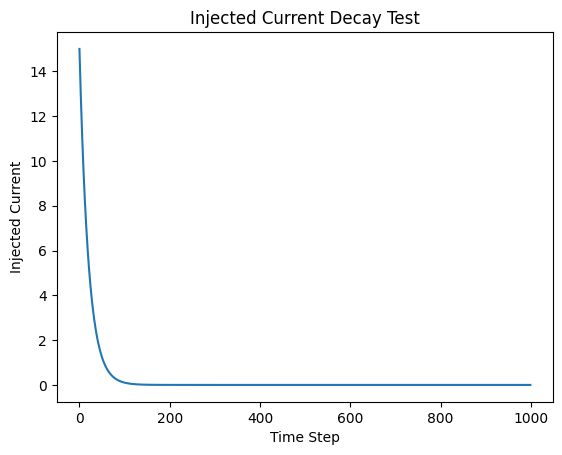

In [14]:
num_steps = 1000
injected_current_decay_parameter = 0.05

injected_current = np.array([15] * num_steps)
exps = np.exp(-injected_current_decay_parameter)**np.arange(num_steps)
injected_current_over_time = injected_current * exps

plt.plot(np.arange(num_steps), injected_current_over_time)
plt.xlabel('Time Step')
plt.ylabel('Injected Current')
plt.title('Injected Current Decay Test')
plt.show()

##### Actual Simulation Function

In [15]:
# Function for Simulation
def SimulateNeurons(
    pos_array,
    edges,
    weights,
    num_time_steps,
    q = 1, # Random process added in 
    vary_neuron_type = False,
    resting_voltage = -70,
    default_a = 0.02,
    default_b = 0.2,
    default_c = -65,
    default_d = 8,
    highest_injected_current = 15,
    t_step_size = 1,
    injected_current_decay_parameter = 0,
    diagnostic_printing = False
):
    '''

    A function to simulate the neurons for a given period of time.

    Parameters:
    ----------

    Returns:
    -------

    '''
    # Create a named tuple object to save results for later
    SimulationResults = namedtuple('SimulationResults', ['voltages', 'us', 'injected_current', 'spikes', 'q', 'num_time_steps', 't_step_size'])

    # Get the number of neurons in the simulation
    n = pos_array.shape[0]
    
    # Create arrays to save the voltages, injected_current, and u's at each time step
    voltages_over_time = np.zeros((num_time_steps, n), dtype = np.float64)
    izhikevich_us_over_time = np.zeros((num_time_steps, n), dtype = np.float64)
    injected_current_over_time = np.zeros((num_time_steps, n), dtype = np.float64)
    spikes_over_time = np.zeros((num_time_steps, n), dtype = np.float64)

    if vary_neuron_type == True:
        # Fill this in more 
        izhikevich_a = np.array([default_a] * n, dtype = np.float64)
        izhikevich_b = np.array([default_b] * n, dtype = np.float64)
        izhikevich_c = np.array([default_c] * n, dtype = np.float64)
        izhikevich_d = np.array([default_d] * n, dtype = np.float64)
        
    else:
        # Have all neurons be regular spiking Izhikevich Neurons
        izhikevich_a = np.array([default_a] * n, dtype = np.float64)
        izhikevich_b = np.array([default_b] * n, dtype = np.float64)
        izhikevich_c = np.array([default_c] * n, dtype = np.float64)
        izhikevich_d = np.array([default_d] * n, dtype = np.float64)        

    # Create an array for the injected current
    highest_injected_current_vec = np.array([highest_injected_current]*n, dtype = np.float64).reshape(1, n)

    # Create arrays for the starting voltages and izhikeivch_us
    voltages = np.array([resting_voltage] * n, dtype = np.float64)
    izhikevich_us = default_b * voltages # np.array([], dtype = np.float64)
    injected_current = np.zeros(n, dtype = np.float64)
    spike_idx = np.zeros(n, dtype = np.float64)

    # Generate random input to the system
    external_noise_array = GeneratePoissoinPointProcess(q, num_time_steps, t_step_size)
        
    for t in range(num_time_steps):
        # Create a new array for random noise at this time step
        random_noise_at_time_step = np.zeros(n, dtype = np.float64)
        
        # Create a diagonal matrix such that that diagonal entry says if this neuron spiked or not
        spike_idx_diag = np.diag(spike_idx)
        
        ## Calculate the injected current at time step
        # Multiply spike_idx_diag by weights to select the rows (neurons) that have spiked.
        spike_adjusted_weights_mat = spike_idx_diag @ weights 

        # Then multiply by the injected current vec to sum down the column, getting the total injected current to the neuron at this time
        injected_current_at_step = highest_injected_current_vec @ spike_adjusted_weights_mat

        # Check if any neurons are getting random injected current at this time step
        external_noise_at_this_time_step_idx = external_noise_array[:, 1] == t
        neurons_getting_external_noise_at_this_time_step = external_noise_array[external_noise_at_this_time_step_idx, 0]
        random_noise_at_time_step[neurons_getting_external_noise_at_this_time_step] = highest_injected_current

        if (np.sum(external_noise_at_this_time_step_idx) != 0) and diagnostic_printing:
            print(f'{t}')
            print('external_noise_at_this_time_step_idx:', external_noise_at_this_time_step_idx)
            print('random_noise_at_time_step:', random_noise_at_time_step, '\n')

        # Add the noise to the injected current at this time step
        injected_current_at_step += random_noise_at_time_step

        # Update the total injected current for the neuron, to take into account any previous
        injected_current += injected_current_at_step.reshape(-1)
        
        # Update voltages, us, and capture nodes that spiked
        voltages, izhikevich_us, spike_idx = IzhikevichNeuron(
            voltages = voltages,
            izhikevich_us = izhikevich_us,
            injected_current = injected_current,
            izhikevich_a = izhikevich_a,
            izhikevich_b = izhikevich_b,
            izhikevich_c = izhikevich_c,
            izhikevich_d = izhikevich_d,
            spike_threshold = 30,
            t_step_size = t_step_size,
            diagnostic_printing = diagnostic_printing
        )

        # Save results to larger matrices
        voltages_over_time[t, :] = voltages
        izhikevich_us_over_time[t, :] = izhikevich_us
        injected_current_over_time[t, :] = injected_current
        spikes_over_time[t, :] = spike_idx

        # Exponential decay to allow the injected current to leak
        injected_current *= np.exp(-injected_current_decay_parameter)

    # Compile results in a named tuple for ease of use
    out = SimulationResults(
        voltages = voltages_over_time,
        us = izhikevich_us_over_time,
        injected_current = injected_current_over_time,
        spikes = spikes_over_time,
        q = q,
        num_time_steps = num_time_steps,
        t_step_size = t_step_size
    )

    return out

In [16]:
constant_weight = 0.3
out = SimulateNeurons(
    pos_array = pos_array, 
    edges = edges, 
    weights = A * constant_weight, 
    num_time_steps = 10000,
    q = 10,
    t_step_size = 0.1,
    injected_current_decay_parameter = 0.05,
    diagnostic_printing = False
)

##### Create a Voltage Plot of the Simulation

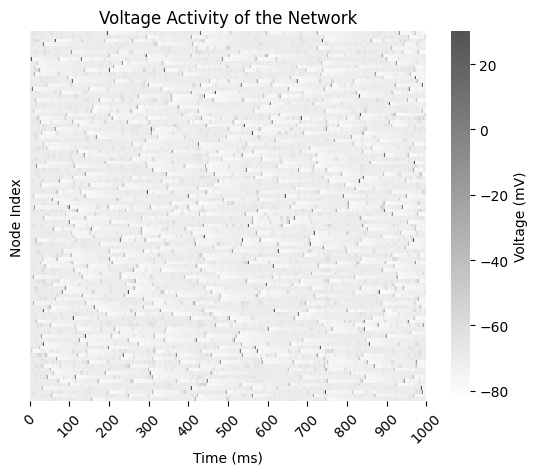

In [17]:
PlotVoltageTrace(
    out, flip_axes=True, 
    include_node_indices=False,
    cmap = 'grey_r'
)

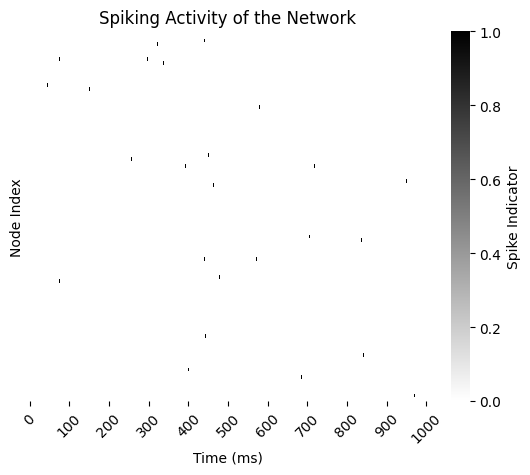

In [18]:
PlotSpikeTrace(
    out, flip_axes=True,
    include_node_indices=False,
    cmap = 'grey_r'
)

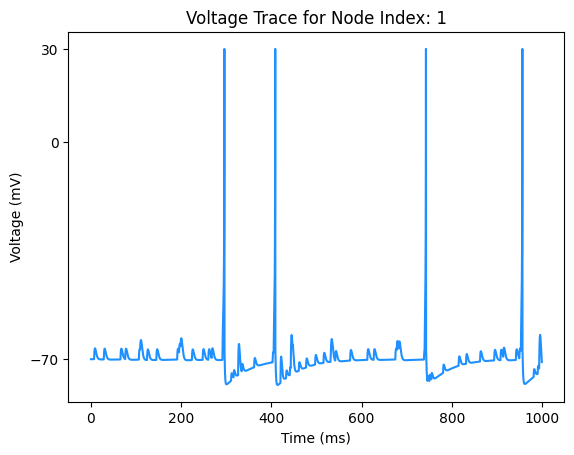

In [19]:
PlotIndividualNodeTrace(out, 1)

### Impact of Different Features

### Explanation of Different Dynamics

# 8. Fit an Appropriate Model

Using the data you generated in your simulation, fit an appropriate model, such as HAVOK or SINDy, or even some kind of elaborate neural network, just has to be appropriate. Use it to predict your data (pick your favorite CV method or equivalent). 

You may assume any level of access you desire to potential “measurements” of a neuron (for example, if your model has a voltage variable that would normally, in biology, be impossible to measure non-destructively or precisely, you have a perfect measurement of it. You need to know the exact number of synapses or the exact geometric structure, sure).  

i) Tell us why you chose the model you did, justify it. How did it do In its prediction?

ii) What is the information that your chosen model needs to perform optimally? If your model were the data generating model of reality, what would that imply about the scientific study of those neurons?

iii)  My goal here:  For you to see how you approach the task of analyzing complex systems data, in a scenario where for the one time in your life you have omniscient knowledge about the data generating process.

### Fitting the Model

### Cross Validation

### Description of Model Choices